In [1]:
import collections
import contextlib
import sys
import wave

import webrtcvad


def read_wave(path):
    """Reads a .wav file.

    Takes the path, and returns (PCM audio data, sample rate).
    """
    with contextlib.closing(wave.open(path, 'rb')) as wf:
        num_channels = wf.getnchannels()
        assert num_channels == 1
        sample_width = wf.getsampwidth()
        assert sample_width == 2
        sample_rate = wf.getframerate()
        assert sample_rate in (8000, 16000, 32000)
        pcm_data = wf.readframes(wf.getnframes())
        return pcm_data, sample_rate


def write_wave(path, audio, sample_rate):
    """Writes a .wav file.

    Takes path, PCM audio data, and sample rate.
    """
    with contextlib.closing(wave.open(path, 'wb')) as wf:
        wf.setnchannels(1)
        wf.setsampwidth(2)
        wf.setframerate(sample_rate)
        wf.writeframes(audio)


class Frame(object):
    """Represents a "frame" of audio data."""
    def __init__(self, bytes, timestamp, duration):
        self.bytes = bytes
        self.timestamp = timestamp
        self.duration = duration


def frame_generator(frame_duration_ms, audio, sample_rate):
    """Generates audio frames from PCM audio data.

    Takes the desired frame duration in milliseconds, the PCM data, and
    the sample rate.

    Yields Frames of the requested duration.
    """
    n = int(sample_rate * (frame_duration_ms / 1000.0) * 2)
    offset = 0
    timestamp = 0.0
    duration = (float(n) / sample_rate) / 2.0
    while offset + n < len(audio):
        yield Frame(audio[offset:offset + n], timestamp, duration)
        timestamp += duration
        offset += n


def vad_collector(sample_rate, frame_duration_ms,
                  padding_duration_ms, vad, frames):
    """Filters out non-voiced audio frames.

    Given a webrtcvad.Vad and a source of audio frames, yields only
    the voiced audio.

    Uses a padded, sliding window algorithm over the audio frames.
    When more than 90% of the frames in the window are voiced (as
    reported by the VAD), the collector triggers and begins yielding
    audio frames. Then the collector waits until 90% of the frames in
    the window are unvoiced to detrigger.

    The window is padded at the front and back to provide a small
    amount of silence or the beginnings/endings of speech around the
    voiced frames.

    Arguments:

    sample_rate - The audio sample rate, in Hz.
    frame_duration_ms - The frame duration in milliseconds.
    padding_duration_ms - The amount to pad the window, in milliseconds.
    vad - An instance of webrtcvad.Vad.
    frames - a source of audio frames (sequence or generator).

    Returns: A generator that yields PCM audio data.
    """
    num_padding_frames = int(padding_duration_ms / frame_duration_ms)
    # We use a deque for our sliding window/ring buffer.
    ring_buffer = collections.deque(maxlen=num_padding_frames)
    # We have two states: TRIGGERED and NOTTRIGGERED. We start in the
    # NOTTRIGGERED state.
    triggered = False

    voiced_frames = []
    for frame in frames:
        sys.stdout.write(
            '1' if vad.is_speech(frame.bytes, sample_rate) else '0')
        if not triggered:
            ring_buffer.append(frame)
            num_voiced = len([f for f in ring_buffer
                              if vad.is_speech(f.bytes, sample_rate)])
            # If we're NOTTRIGGERED and more than 90% of the frames in
            # the ring buffer are voiced frames, then enter the
            # TRIGGERED state.
            if num_voiced > 0.9 * ring_buffer.maxlen:
                triggered = True
                sys.stdout.write('+(%s)' % (ring_buffer[0].timestamp,))
                # We want to yield all the audio we see from now until
                # we are NOTTRIGGERED, but we have to start with the
                # audio that's already in the ring buffer.
                voiced_frames.extend(ring_buffer)
                ring_buffer.clear()
        else:
            # We're in the TRIGGERED state, so collect the audio data
            # and add it to the ring buffer.
            voiced_frames.append(frame)
            ring_buffer.append(frame)
            num_unvoiced = len([f for f in ring_buffer
                                if not vad.is_speech(f.bytes, sample_rate)])
            # If more than 90% of the frames in the ring buffer are
            # unvoiced, then enter NOTTRIGGERED and yield whatever
            # audio we've collected.
            if num_unvoiced > 0.9 * ring_buffer.maxlen:
                sys.stdout.write('-(%s)' % (frame.timestamp + frame.duration))
                triggered = False
                yield b''.join([f.bytes for f in voiced_frames])
                ring_buffer.clear()
                voiced_frames = []
    if triggered:
        sys.stdout.write('-(%s)' % (frame.timestamp + frame.duration))
    sys.stdout.write('\n')
    # If we have any leftover voiced audio when we run out of input,
    # yield it.
    if voiced_frames:
        yield b''.join([f.bytes for f in voiced_frames])

In [3]:
#if len(args) != 2:
#sys.stderr.write(
#        'Usage: example.py <aggressiveness> <path to wav file>\n')
#    sys.exit(1)
vad_mode = 3
fname = 'leak-test.wav'
audio, sample_rate = read_wave(fname)
vad = webrtcvad.Vad(vad_mode)
frames = frame_generator(30, audio, sample_rate)
frames = list(frames)
segments = vad_collector(sample_rate, 30, 300, vad, frames)
for i, segment in enumerate(segments):
    path = 'chunk-%002d.wav' % (i,)
    print(' Writing %s' % (path,))
    write_wave(path, segment, sample_rate)



00000000000000000000111101111+(0.5700000000000003)1111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111110000000-(4.229999999999991) Writing chunk-00.wav
000011111111+(4.289999999999991)11111111111111111111111011111011111111111111111111111111000000000-(6.54000000000001) Writing chunk-01.wav
1111111111+(6.54000000000001)1111111111111111111111110000000-(7.77000000000002) Writing chunk-02.wav
00000000000000000000000000000000000000000000000000000


In [9]:
audio

b'\x0e\x00\x0c\x00\t\x00\xff\xff\x08\x00\x01\x00\xf0\xff\xf8\xff\xff\xff\x01\x00\xff\xff\x01\x00\xff\xff\x00\x00\xff\xff\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xff\xff\x00\x00\x00\x00\x00\x00\x00\x00\xff\xff\x00\x00\x00\x00\xff\xff\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\xff\xff\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\xff\xff\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\xff\xff\x00\x00\xff\xff\x00\x00\x01\x00\xff\xff\x00\x00\x00\x00\x00\x00\xff\xff\x00\x00\x00\x00\xff\xff\x00\x00\x00\x00\x00\x00\xfe\xff\xfd\xff\xfe\xff\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xff\xff\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\xff\xff\x01\x00\xff\xff\x01\x00\xff\xff\x01\x00\xff\xff\x00\x00\xff\xff\x01\x00\xff\xff\x01\x00\xff\xff\x01\x00\x00\x00\x00\x00\x01\x00\x00\x00\x02\x00\xfe\xff\x02\x00\xfd\xff\x03\x00\xfc\xff\x05\x00\xfb\xff\x05\x00

In [5]:
segments

<generator object vad_collector at 0x7f430c774e08>

In [7]:
segments.shape

AttributeError: 'generator' object has no attribute 'shape'

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import uniform
%matplotlib inline 
fs = 2000  # hz
length = 3 # second
t = np.linspace(0, length, num=fs, endpoint=False)
#x = 0.891 * np.sin(2* np.pi * fs*t)
dither = uniform(low=-1/2**16, high=1/2**16, size=len(t))

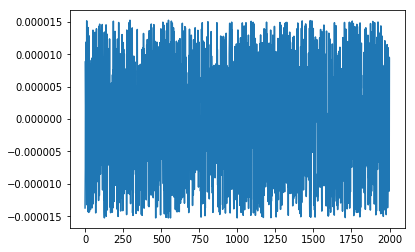

In [24]:
plt.plot(dither)